In [1]:
from hydra import initialize, compose
from hydra.core.global_hydra import GlobalHydra
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json
from PIL import Image
import sklearn.metrics
import itertools
from functools import partial
from skimage.morphology import label

from hoechstgan.data import create_dataset
from hoechstgan.models import create_model
from hoechstgan.util import tensor2im
from hoechstgan.util.dataset import get_channel_file_from_metadata

GlobalHydra().clear()
initialize(config_path="conf")
cfg = compose("test.yaml", overrides=["name=raw"])

print(OmegaConf.to_yaml({"input": cfg.dataset.input, "output": cfg.dataset.output}))

model = create_model(cfg)
model.setup(cfg)

dataset = create_dataset(cfg)

input:
  props:
    channel: H3342
    mode: raw
  transforms: []
  num_channels: 1
output:
  props:
    channel: CD3
    mode: mask
    mask_type: cells
  transforms:
  - distance_transform
  num_channels: 1

initialize network with normal
loading the model from /data/checkpoints/raw/latest_net_G.pth
---------- Networks initialized -------------
DataParallel(
  (module): UnetGenerator(
    (model): UnetSkipConnectionBlock(
      (model): Sequential(
        (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): UnetSkipConnectionBlock(
          (model): Sequential(
            (0): LeakyReLU(negative_slope=0.2, inplace=True)
            (1): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
            (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): UnetSkipConnectionBlock(
              (model): Sequential(
                (0): LeakyReLU(negative_slope=0.2, inp

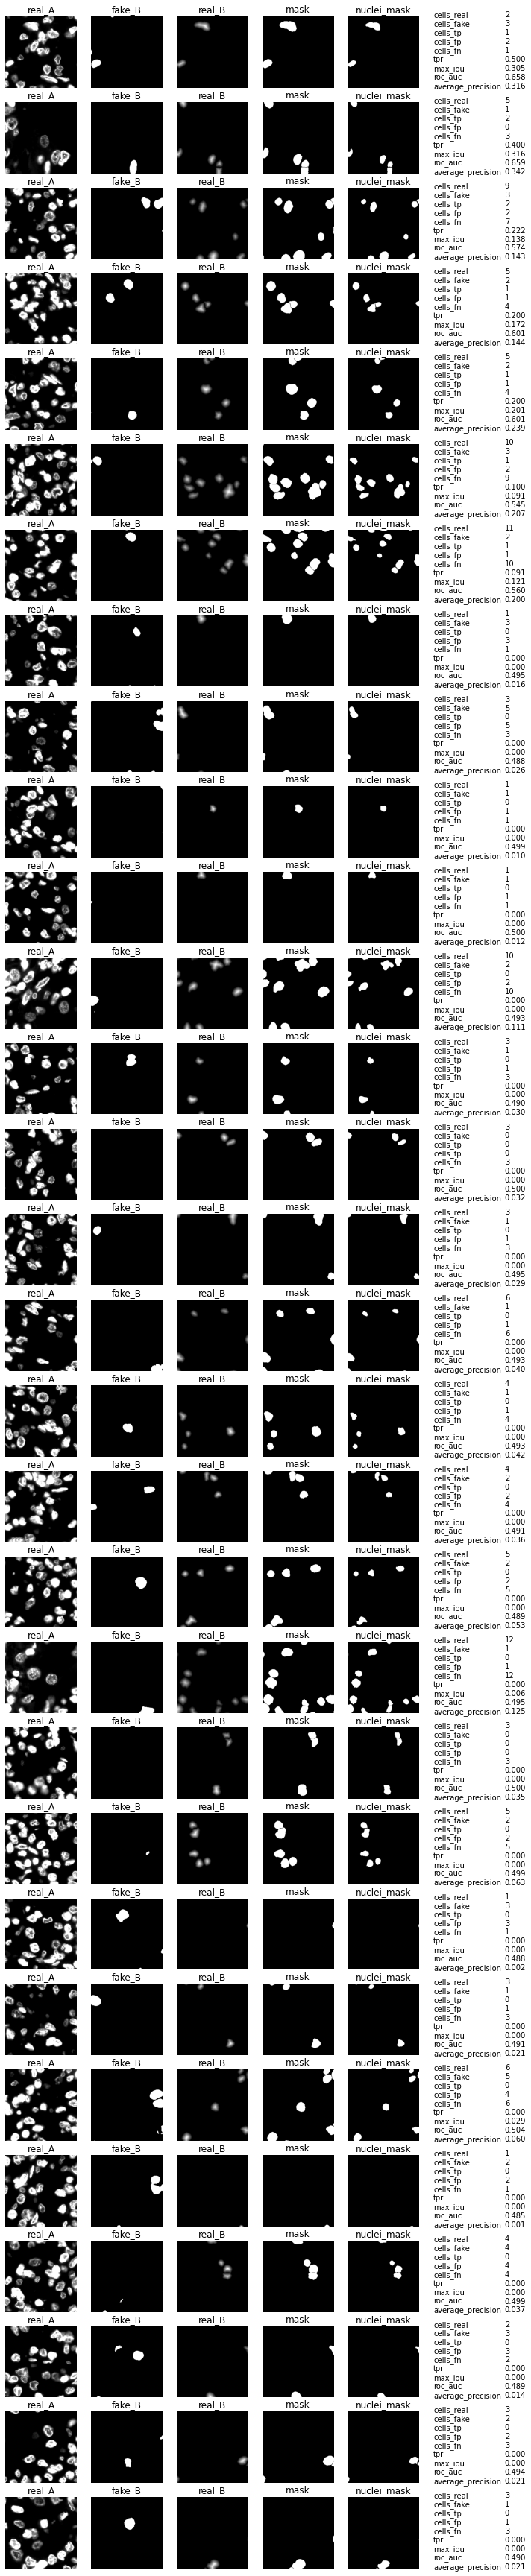

In [3]:
def compute_iou(A, B):
    I = (A & B).sum()
    U = (A | B).sum()
    return I / U if U > 0 else np.inf 

def get_img(tensor):
    return (tensor.cpu().numpy().squeeze() + 1) / 2.

def perform_test(data, model):
    model.set_input(data)
    model.test()

    for json_path, real_A, fake_B, real_B in zip(data["json_files"], model.real_A, model.fake_B, model.real_B):
        json_path = Path(json_path)
        with json_path.open("r") as f:
            meta = json.load(f)

        def get_mask(mask_type: str):
            mask_path = json_path.with_name(get_channel_file_from_metadata(meta, "CD3", "mask", mask_type=mask_type))
            mask = Image.open(mask_path).convert("L")
            mask = np.array(mask)
            mask = mask != 0
            return mask
        
        mask = get_mask("cells")
        nuclei_mask = get_mask("nuclei")

        fake = get_img(fake_B)

        thresholds = np.linspace(0., 1., 10)
        ious = [compute_iou(mask, fake > t) for t in thresholds]

        def sklearn_metric(metric):
            try:
                return metric(mask.flatten(), fake.flatten())
            except ValueError:
                return np.inf
        
        l_real = label(nuclei_mask, connectivity=1)
        l_fake = label(fake > .5, connectivity=1)

        num_cells_real = l_real.max()
        num_cells_fake = l_fake.max()

        proportion_positive_pixels_per_real_cell = np.array([((fake > .5) & (l_real == i)).sum() / (l_real == i).sum()
                                                             for i in range(1, num_cells_real + 1)])
        proportion_true_pixels_per_fake_cell = np.array([(nuclei_mask & (l_fake == i)).sum() / (l_fake == i).sum()
                                                         for i in range(1, num_cells_fake + 1)])

        P = num_cells_real
        TP = (proportion_positive_pixels_per_real_cell > .5).sum()
        FP = (proportion_true_pixels_per_fake_cell < .5).sum()
        FN = P - TP
        TPR = TP / P if P > 0. else np.inf

        return {
            "metrics": {
                "cells_real": num_cells_real,
                "cells_fake": num_cells_fake,
                "cells_tp": TP,
                "cells_fp": FP,
                "cells_fn": FN,
                "tpr": TPR,
                "max_iou": max(ious),
                "roc_auc": sklearn_metric(sklearn.metrics.roc_auc_score),
                "average_precision": sklearn_metric(sklearn.metrics.average_precision_score),
            },
            "visuals": {
                "real_A": get_img(real_A),
                "fake_B": get_img(fake_B),
                "real_B": get_img(real_B),
                "mask": mask.astype(float),
                "nuclei_mask": nuclei_mask.astype(float)
            }
        }

metric = "tpr"
res = itertools.islice(map(partial(perform_test, model=model), dataset), 30)
res = list(reversed(sorted(res, key=lambda x: x["metrics"][metric])))

def subplot(rows, cols, row, col):
    return plt.subplot(rows, cols, cols * row + col + 1)

plt.figure(figsize=(12, len(res) * 2.1))
for row, r in enumerate(res):
    visuals = r["visuals"]
    metrics = r["metrics"]
    splot = partial(subplot, len(res), len(visuals) + 1)
    for col, (name, visual) in enumerate(visuals.items()):
        splot(row, col)
        plt.imshow(visual, cmap="gray")
        plt.title(name)
        plt.axis("off")
    splot(row, col + 1)
    for y, (k, v) in zip(np.linspace(0., 1., len(metrics)), reversed(metrics.items())):
        plt.text(0., y, k)
        plt.text(1., y, f"{v:.3f}" if isinstance(v, float) else str(v))
    plt.axis("off")